In [1]:
import typing as tp
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
# StanfordCars
# log_file_path = outputs_dir / "2022-10-03/17-14-25/image_attention.log"
# EuroSat
# log_file_path = outputs_dir / "2023-05-22/05-46-31/image_attention.log"

In [3]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [4]:
def load_log_records(*log_files_paths: Path, record_type: tp.Optional[str] = None) -> pd.DataFrame:
    files_records = []
    for log_file_path in log_files_paths:
        log_records = load_records(log_file_path)
        log_records = [record for record in log_records if record['message'] is None]
        if record_type is not None:
            log_records = [record for record in log_records if record.get('type') == record_type]
        files_records.extend(log_records)

    log_records_df = pd.json_normalize(files_records).drop(columns=['message', 'asctime'])
    return log_records_df

In [5]:
def add_zero_shots(log_records_df: pd.DataFrame, column_to_value: tp.Dict[str, tp.Any]) -> pd.DataFrame:
    zero_shot_df = log_records_df[log_records_df['alpha'] == 0].copy()
    for col_name, col_value in column_to_value.items():
        zero_shot_df[col_name] = col_value
    zero_shot_dfs = []

    for alpha in log_records_df['alpha'].unique():
        alpha_df = zero_shot_df.copy()
        alpha_df['alpha'] = alpha
        zero_shot_dfs.append(alpha_df)

    return pd.concat([log_records_df] + zero_shot_dfs, ignore_index=True)

In [6]:
def filter_records(part_df: pd.DataFrame, alpha: tp.Set[tp.Any], beta: tp.Set[tp.Any], topks: tp.Set[tp.Any]) -> pd.DataFrame:
    alpha_mask = part_df['alpha'].isin(alpha)
    beta_mask = part_df['cache_weights_strategy.beta'].isin(beta)
    topk_mask = part_df['cache_strategy.topk'].isin(topks)

    return part_df[alpha_mask & beta_mask & topk_mask]

In [7]:
alpha = {0.1, 2.0, 4.0}
beta = {1.5, 7.5, 11.5}
topks = {1, 2, 4, 8, 16}

## Samples strategy comparison

In [65]:
log_files_map = {
    "eurosat": "2023-05-16/01-57-48/image_attention.log",
    "stanford_cars": "2023-05-16/01-50-38/image_attention.log",
    "imagenet": "2023-05-16/02-28-15/image_attention.log",
    "caltech101": "2023-05-16/03-24-24/image_attention.log",
    "oxford_pets": "2023-05-16/05-34-57/image_attention.log",
    "oxford_flowers": "2023-05-16/07-11-54/image_attention.log",
    "food101": "2023-05-16/07-52-59/image_attention.log",
    "fgvc": "2023-05-16/08-16-34/image_attention.log",
    "dtd": "2023-05-16/08-42-32/image_attention.log",
    "ucf101": "2023-05-16/09-08-24/image_attention.log",
    "sun397": "2023-05-16/18-28-31/image_attention.log",
}

In [14]:
CURRENT_DATASET = "sun397"

log_files_paths = [outputs_dir / log_files_map[CURRENT_DATASET]]

In [21]:
def fill_topk(log_records_df: pd.DataFrame) -> pd.DataFrame:
    topk_mask = log_records_df['cache_strategy.topk'].isna()
    full_topk_df = log_records_df[~topk_mask]
    empty_topk_df = log_records_df[topk_mask]

    topk_dfs = []
    for topk in full_topk_df['cache_strategy.topk'].unique():
        topk_df = empty_topk_df.copy()
        topk_df['cache_strategy.topk'] = topk
        topk_dfs.append(topk_df)

    return pd.concat([full_topk_df] + topk_dfs, ignore_index=True)

In [22]:
def shrink_strategies(log_records_df: pd.DataFrame) -> pd.DataFrame:
    def shrink_strategy_name(strategy_name: str) -> str:
        prefix = 'summer_clip.clip_searcher.cache_strategy.'
        if not strategy_name.startswith(prefix):
            return strategy_name
        return strategy_name[len(prefix):]

    log_records_df['cache_strategy._target_'] = (
        log_records_df['cache_strategy._target_'].apply(shrink_strategy_name)
    )
    return log_records_df

In [23]:
def prepare_part_df(*log_files_paths):
    log_records_df = load_log_records(*log_files_paths, record_type='searcher_result')
    log_records_df = fill_topk(log_records_df)
    columns_to_drop = [
        column for column in log_records_df.columns
        if column.startswith('cache_strategy.cache_dataset') \
        or column.startswith('cache_strategy.scale')
    ]
    log_records_df = log_records_df.drop(columns=columns_to_drop)
    log_records_df = add_zero_shots(log_records_df, {'cache_strategy._target_': 'summer_clip.clip_searcher.cache_strategy.ZeroShotStrategy'})
    log_records_df = shrink_strategies(log_records_df)

    visible_params = {
        'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
        'cache_weights_strategy.beta', 'cache_value_strategy.scale',
        'cache_strategy._target_',
    }
    static_columns = list(set(log_records_df.columns) - visible_params)
    groups = list(log_records_df.groupby(static_columns, dropna=False))
    assert len(groups) == 1, "There should be only one group"
    
    static_values, part_df = groups[0]
    part_df = filter_records(part_df, alpha, beta, topks)
    return part_df

In [24]:
def set_up_fonts():
    sns.set_context("paper", rc={
        "font.size": 15,"axes.titlesize": 14,"axes.labelsize": 14,
        "legend.fontsize": 14, "legend.title_fontsize": 14,
        "xtick.labelsize": 14, "ytick.labelsize": 14
    })

In [25]:
def prepare_for_figure(part_df, strategy_name_mapper):
    part_df = part_df[part_df['cache_strategy._target_'].isin(strategy_name_mapper)].copy()
    part_df['cache_strategy._target_'] = part_df['cache_strategy._target_'].apply(lambda strategy: strategy_name_mapper[strategy])
    part_df['cache_strategy.topk'] = part_df['cache_strategy.topk'].astype(int)
    part_df = part_df.rename(columns={
        'cache_strategy.topk': 'k', 'acc1': 'acc@1 (%)', 'alpha': r'$\alpha$',
        'cache_weights_strategy.beta': r'$\beta$', 'cache_strategy._target_': 'Strategy'
    })
    return part_df

In [26]:
def make_strategy_name_mapper():
    strategy_name_mapper = {
        'TopKProbStrategy': 'topk',
        'PerPredClassRandomSampleStrategy': 'per_pred_random',
        'GlobalRandomSampleStrategy': 'global_random',
        'AllLogitsStrategy': 'all_logits',
        'ZeroShotStrategy': 'zero_shot'
    }
    strategies = list(strategy_name_mapper.values())
    markers = ['o', 'o', 'o', 'o', 'D']
    linestyles = ['-', '--', '--', '--', '-']
    palette = ['C3', 'C0', 'C2', 'C4', 'C1']
    return strategy_name_mapper, strategies, markers, linestyles, palette

In [27]:
def plot_diff_params(part_df):
    set_up_fonts()
    strategy_name_mapper, strategies, markers, linestyles, palette = make_strategy_name_mapper()
    part_df = prepare_for_figure(part_df, strategy_name_mapper)
    fig = sns.catplot(
        data=part_df, x='k', y='acc@1 (%)', col=r'$\alpha$',
        row=r'$\beta$', kind='point', hue='Strategy', legend_out=False, hue_order=strategies, markers=markers,
        linestyles=linestyles, palette=palette
    )
    fig.set_xlabels('Number of examples per class')
    for ax in fig.axes.flatten():
        ax.grid(linestyle='--') 
    fig.fig.subplots_adjust(top=0.94)
    fig.fig.suptitle('SUN397')
    plt.savefig('data/clip_search_71.pdf')

In [ ]:
part_df = prepare_part_df(*log_files_paths)

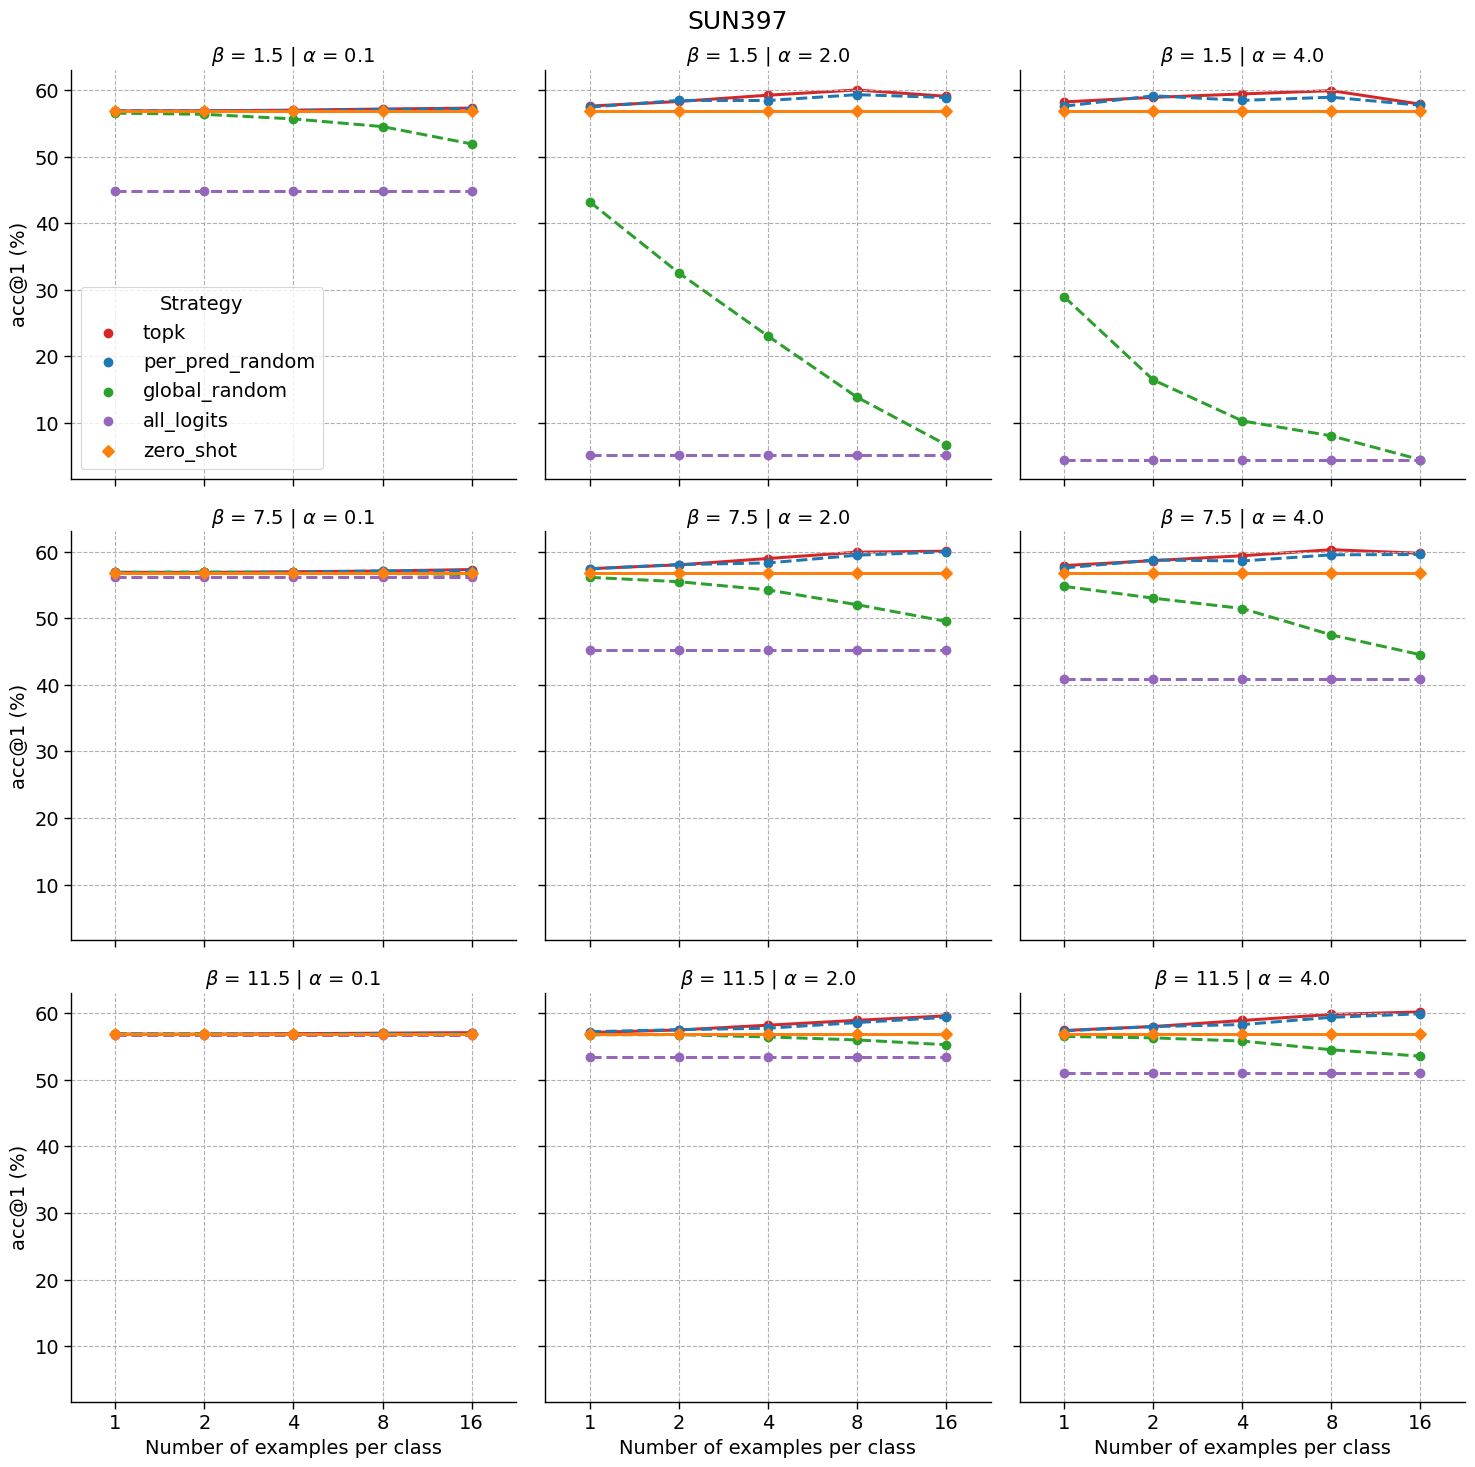

In [44]:
plot_diff_params(part_df)

### All datasets figures

In [69]:
dataset_to_df = {
    dataset_name: prepare_part_df(outputs_dir / log_file_path)
    for dataset_name, log_file_path in log_files_map.items()
}

In [96]:
dataset_key_to_name = {
    "eurosat": "EuroSAT",
    "stanford_cars": "StanfordCars",
    "imagenet": "ImageNet",
    "caltech101": "Caltech101",
    "oxford_pets": "OxfordPets",
    "oxford_flowers": "Flowers102",
    "food101": "Food101",
    "fgvc": "FGVCAircraft",
    "dtd": "DTD",
    "ucf101": "UCF101",
    "sun397": "SUN397",
}

In [29]:
datasets_order = [
    'dtd', 'oxford_flowers', 'eurosat', 'ucf101', 'caltech101',
    'stanford_cars', 'food101', 'oxford_pets', 'fgvc', 'imagenet'
]

In [54]:
def plot_all_datasets(dataset_to_df, ncols=5, alpha=2.0, beta=7.5, drop_last_strategy=False):
    set_up_fonts()
    strategy_name_mapper, strategies, markers, linestyles, palette = make_strategy_name_mapper()
    if drop_last_strategy:
        strategies = strategies[:-1]
    dfs = []
    for dataset_name in datasets_order:
        name_df = dataset_to_df[dataset_name].copy()
        if (alpha is not None) and (beta is not None):
            name_df = name_df[(name_df['alpha'] == alpha) & (name_df['cache_weights_strategy.beta'] == beta)]
        name_df = prepare_for_figure(name_df, strategy_name_mapper)
        dataset_ind = datasets_order.index(dataset_name)
        name_df['col'] = dataset_ind % ncols
        name_df['row'] = dataset_ind // ncols
        dfs.append(name_df)
    dfs = pd.concat(dfs, axis=0)
    fig = sns.catplot(
        data=dfs, x='k', y='acc@1 (%)', col='col', row='row',
        kind='point', hue='Strategy', legend_out=False, hue_order=strategies,
        markers=markers, linestyles=linestyles, palette=palette,
        sharex=False, sharey=False,
    )
    fig.set_xlabels('Number of examples per class')
    for ax, dataset_name in zip(fig.axes.flatten(), datasets_order):
        ax.grid(linestyle='--')
        ax.set_title(dataset_key_to_name[dataset_name])
    plt.savefig('data/clip_search_72.pdf')

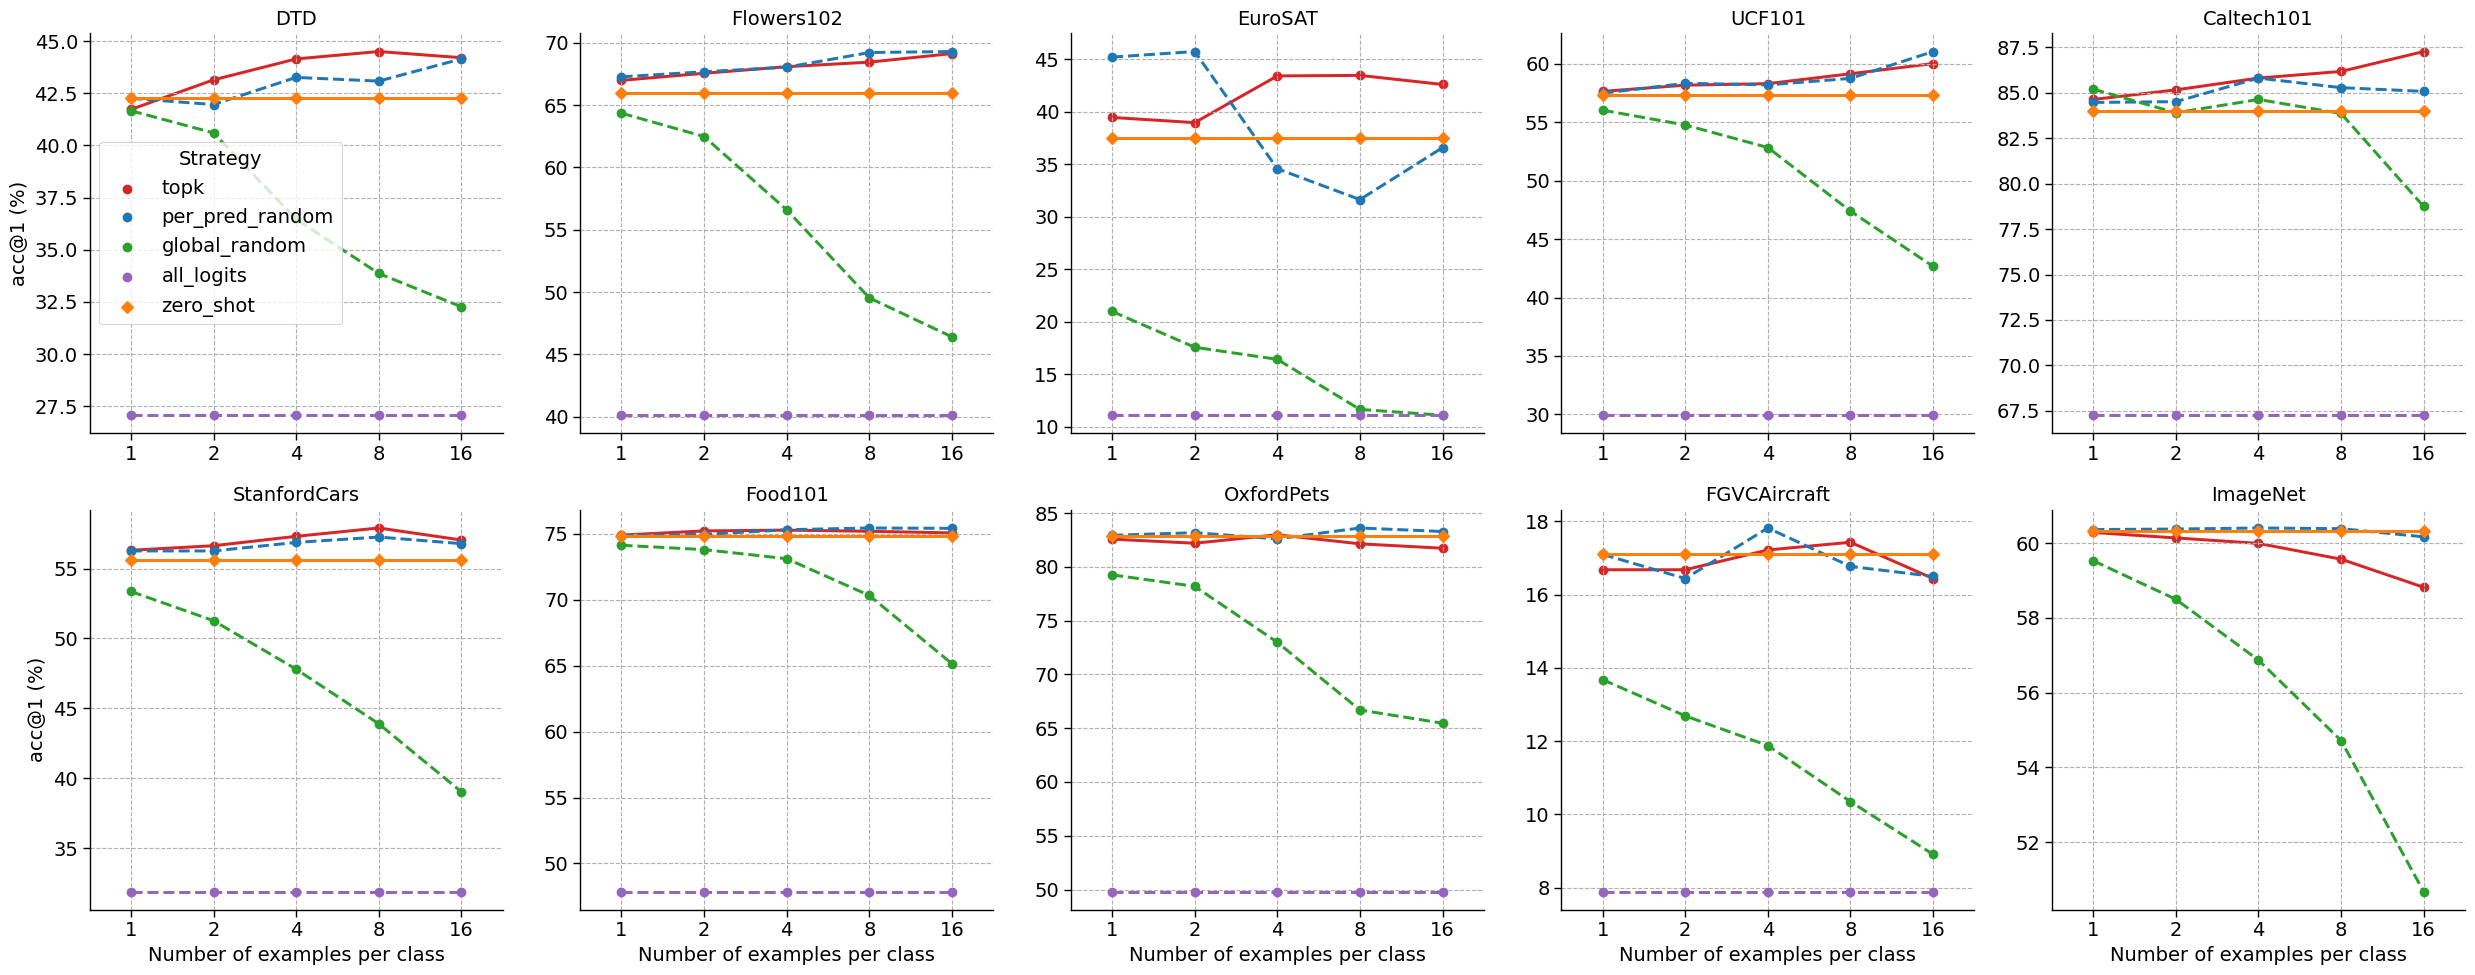

In [55]:
plot_all_datasets(dataset_to_df)

### All datasets cache quality

In [56]:
def prepare_cache_df(*log_files_paths):
    log_records_df = load_log_records(*log_files_paths, record_type='cache_info')
    log_records_df = fill_topk(log_records_df)
    log_records_df = shrink_strategies(log_records_df)
    log_records_df = log_records_df[log_records_df['cache_strategy.topk'].isin(topks)]
    return log_records_df

In [57]:
dataset_cache_to_df = {
    dataset_name: prepare_cache_df(outputs_dir / log_file_path)
    for dataset_name, log_file_path in log_files_map.items()
}

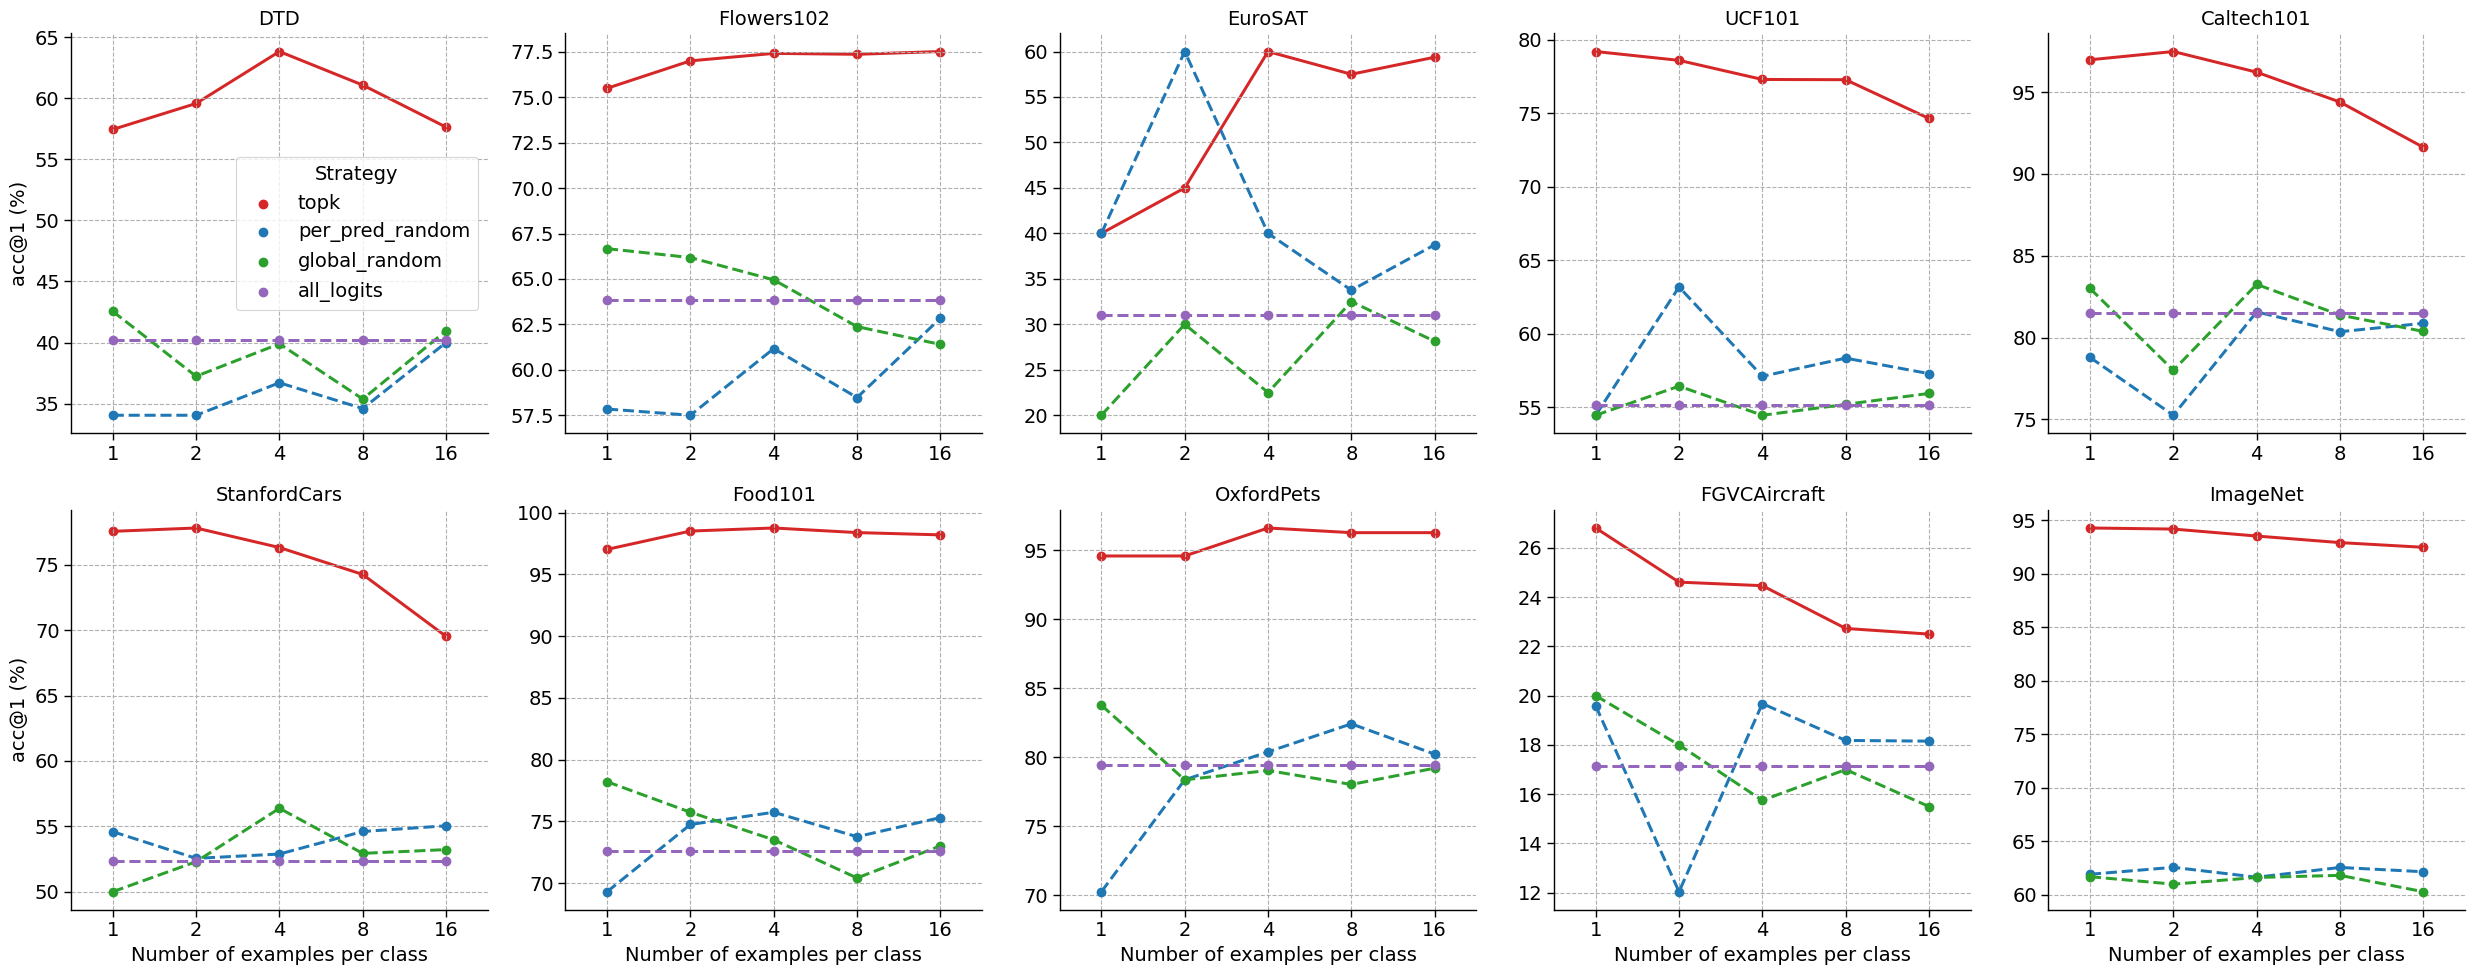

In [58]:
plot_all_datasets(dataset_cache_to_df, alpha=None, beta=None, drop_last_strategy=True)  # type: ignore

### Soft cache values

In [55]:
soft_log_files_map = {
    "eurosat": "2023-05-22/05-46-31/image_attention.log",
    "stanford_cars": "2023-05-22/17-16-44/image_attention.log",
    "imagenet": "2023-05-22/17-29-47/image_attention.log",
    "caltech101": "2023-05-22/17-32-27/image_attention.log",
    "oxford_pets": "2023-05-22/17-36-31/image_attention.log",
    "oxford_flowers": "2023-05-22/17-37-26/image_attention.log",
    "food101": "2023-05-22/17-39-01/image_attention.log",
    "fgvc": "2023-05-22/17-40-31/image_attention.log",
    "dtd": "2023-05-22/17-45-32/image_attention.log",
    "ucf101": "2023-05-22/17-46-34/image_attention.log",
    "sun397": "2023-05-22/17-47-45/image_attention.log",
}

In [56]:
def prepare_soft_df(dataset_name):
    log_file_path = outputs_dir / soft_log_files_map[dataset_name]
    
    log_records_df = load_log_records(log_file_path, record_type='searcher_result')
    log_records_df = log_records_df.drop(columns='cache_value_strategy.clip_scale')
    log_records_df['cache_value_strategy.scale'] = log_records_df['cache_value_strategy.scale'].apply(lambda scale: f'soft: {scale}')

    # adding hard_cache strategy
    hard_cache_log_file_path = outputs_dir / log_files_map[dataset_name]
    hard_log_records_df = load_log_records(hard_cache_log_file_path, record_type='searcher_result')
    hard_log_records_df = hard_log_records_df[hard_log_records_df['cache_strategy._target_'] == 'summer_clip.clip_searcher.cache_strategy.TopKProbStrategy']

    hard_log_records_df['cache_value_strategy._target_'] = 'summer_clip.clip_searcher.cache_value_strategy.SoftmaxCacheStrategy'
    hard_log_records_df['cache_value_strategy.scale'] = 'topk'
    hard_log_records_df = hard_log_records_df[log_records_df.columns]

    log_records_df = pd.concat([log_records_df, hard_log_records_df], ignore_index=True)
    log_records_df = add_zero_shots(log_records_df, {'cache_value_strategy.scale': 'zero_shot'})
    
    visible_params = {
        'alpha', 'acc1', 'acc5', 'cache_strategy.topk',
        'cache_weights_strategy.beta', 'cache_value_strategy.scale'
    }
    static_columns = list(set(log_records_df.columns) - visible_params)
    groups = list(log_records_df.groupby(static_columns))
    assert len(groups) == 1

    log_records_df = filter_records(log_records_df, alpha, beta, topks)
    return log_records_df

In [57]:
def prepare_soft_df_for_figure(part_df):
    part_df['cache_strategy.topk'] = part_df['cache_strategy.topk'].astype(int)
    part_df = part_df.rename(columns={
        'cache_strategy.topk': 'k', 'acc1': 'acc@1 (%)', 'alpha': r'$\alpha$',
        'cache_weights_strategy.beta': r'$\beta$', 'cache_strategy._target_': 'Strategy',
        'cache_value_strategy.scale': 'Value strategy', 
    })
    return part_df

In [58]:
def plot_all_datasets(soft_dataset_to_df, ncols=5, alpha=2.0, beta=7.5):
    set_up_fonts()
    dfs = []
    for dataset_name in datasets_order:
        name_df = soft_dataset_to_df[dataset_name].copy()
        name_df = name_df[(name_df['alpha'] == alpha) & (name_df['cache_weights_strategy.beta'] == beta)]
        name_df = prepare_soft_df_for_figure(name_df)
        dataset_ind = datasets_order.index(dataset_name)
        name_df['col'] = dataset_ind % ncols
        name_df['row'] = dataset_ind // ncols
        dfs.append(name_df)
    dfs = pd.concat(dfs, axis=0)
    fig = sns.catplot(
        data=dfs, x='k', y='acc@1 (%)', col='col', row='row',
        kind='point', hue='Value strategy', legend_out=False, markers=['o', 'o', 'o', 'o', 'o', 'D'],
        linestyles=['-', '-', '-', '-', '--', '--'], palette=['C0', 'C2', 'C4', 'C6', 'C3', 'C1'],
        sharex=False, sharey=False,
    )
    fig.set_xlabels('Number of examples per class')
    for ax, dataset_name in zip(fig.axes.flatten(), datasets_order):
        ax.grid(linestyle='--')
        ax.set_title(dataset_key_to_name[dataset_name])

In [59]:
datasets_order = [
    'dtd', 'oxford_flowers', 'eurosat', 'ucf101', 'caltech101',
    'stanford_cars', 'food101', 'oxford_pets', 'fgvc', 'imagenet'
]

In [60]:
soft_dataset_to_df = {
    dataset_name: prepare_soft_df(dataset_name)
    for dataset_name in soft_log_files_map.keys()
}

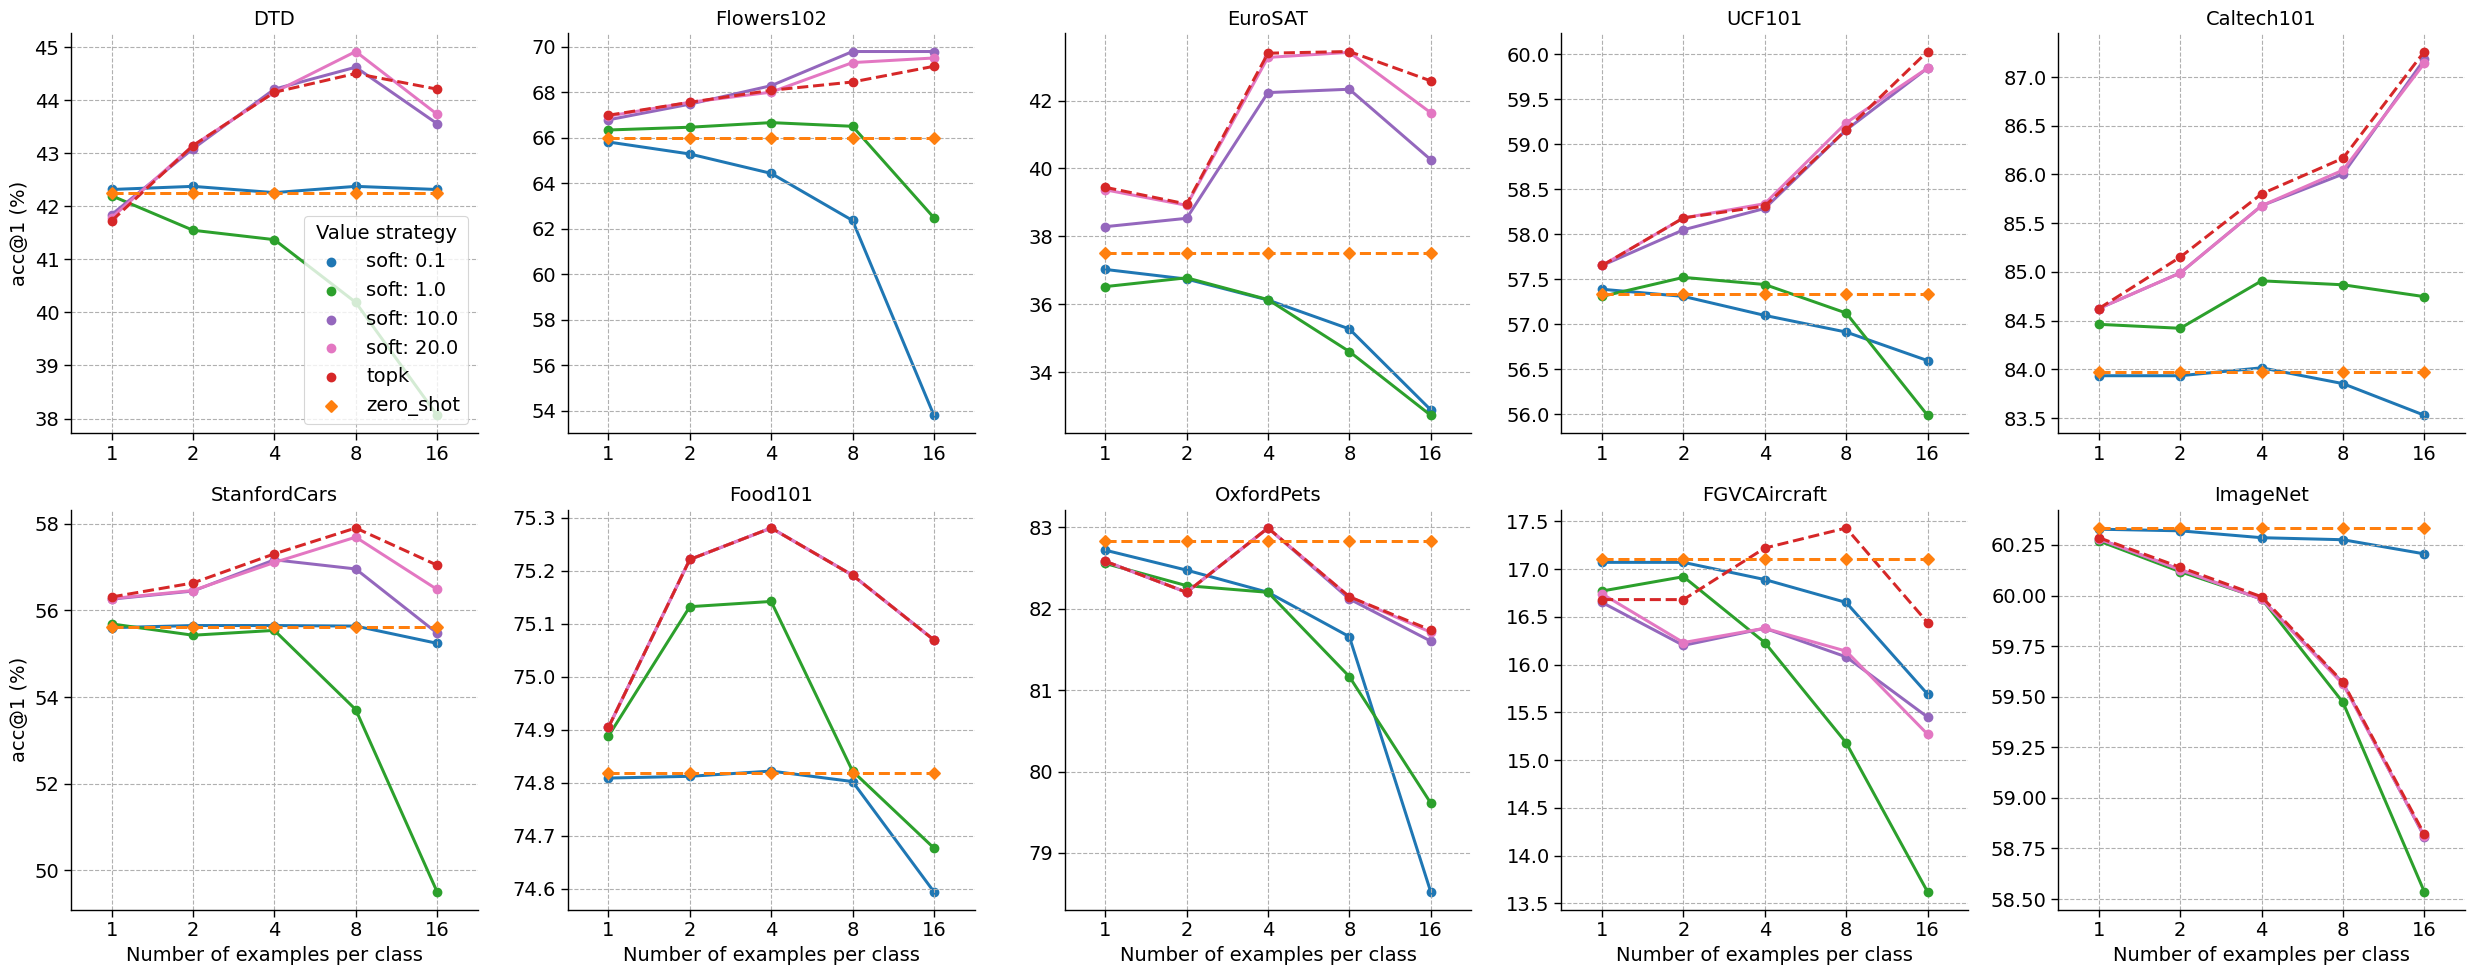

In [62]:
plot_all_datasets(soft_dataset_to_df)
plt.savefig('data/soft_cache_1.pdf')

### Result tables

In [91]:
datasets_order = [
    'sun397', 'dtd', 'oxford_flowers', 'eurosat', 'ucf101', 'caltech101',
    'stanford_cars', 'food101', 'oxford_pets', 'fgvc', 'imagenet'
]

In [112]:
def construct_concat_df(alpha=2.0, beta=7.5, topk=16, strategy='TopKProbStrategy'):
    concat_df = []
    for dataset_name in datasets_order:
        dataset_df = dataset_to_df[dataset_name]
        dataset_df = dataset_df.copy()
        dataset_df['dataset'] = dataset_name
        df_strategy = dataset_df['cache_strategy._target_'].apply(lambda class_path: class_path.split('.')[-1])
        dataset_df = dataset_df[
            (dataset_df['alpha'] == alpha) & 
            (dataset_df['cache_weights_strategy.beta'] == beta) &
            (dataset_df['cache_strategy.topk'] == topk) &
            (df_strategy == strategy)
        ]
        concat_df.append(dataset_df)
    concat_df = pd.concat(concat_df, axis=0, ignore_index=True)
    return concat_df[['dataset', 'acc1']]

In [116]:
# Is taken from: https://github.com/gaopengcuhk/Tip-Adapter/blob/main/exp.log

tip_adapter_results = pd.DataFrame([
    ('imagenet', 62.01, 65.51),
    ('sun397', 66.85, 71.47),
    ('oxford_pets', 88.14, 89.70),
    ('eurosat', 70.54, 84.54),
    ('caltech101', 90.18, 92.86),
    ('dtd', 60.93, 66.55),
    ('fgvc', 29.76, 35.55),
    ('food101', 77.83, 79.43),
    ('oxford_flowers', 89.89, 94.80),
    ('ucf101', 70.58, 78.03),
    ('stanford_cars', 66.77, 75.74),
], columns=('dataset', 'tip', 'tip-f'))

In [120]:
# Is taken from: https://docs.google.com/spreadsheets/d/12_kaFdD0nct9aUIrDoreY0qDunQ9q9tv/edit?usp=sharing&ouid=100312610418109826457&rtpof=true&sd=true

coop_results = pd.DataFrame({
    'dataset': ['oxford_pets', 'oxford_flowers', 'fgvc', 'dtd', 'eurosat', 'stanford_cars', 'food101', 'sun397', 'caltech101', 'ucf101', 'imagenet'],
    'coop': [87.01, 94.51, 31.26, 63.58, 83.53, 73.36, 74.67, 69.26, 91.83, 75.71, 62.95]
})

In [119]:
upl_results = pd.DataFrame({
    'dataset': ['imagenet', 'caltech101', 'dtd', 'eurosat', 'fgvc', 'food101', 'oxford_flowers', 'oxford_pets', 'sun397', 'stanford_cars', 'ucf101'],
    'upl': [60.51, 89.94, 46.57, 54.83, 17.34, 77.58, 68.90, 88.28, 63.98, 62.13, 67.17]
})

In [131]:
# Is taken from: https://docs.google.com/spreadsheets/d/1_d7nvKM4xlc1ryI8yk1yiI_KrY0t0P3qYaeuBL3__w8/edit#gid=1008533228

svl_results = pd.DataFrame({
    'dataset': ['oxford_pets', 'oxford_flowers', 'fgvc', 'dtd', 'eurosat', 'stanford_cars', 'food101', 'sun397', 'caltech101', 'ucf101'],
    'svl': [87.9, 73.28, 12.42, 47.1, 66.28, 50.27, 78.43, 61.37, 88.64, 64.9]
})

In [134]:
clip_search_df = construct_concat_df(strategy='TopKProbStrategy')
clip_search_df = clip_search_df.rename(columns={'acc1': 'topk'})

zeroshot_df = construct_concat_df(strategy='ZeroShotStrategy')
zeroshot_df = zeroshot_df.groupby('dataset').first().reset_index()
zeroshot_df = zeroshot_df.rename(columns={'acc1': 'zero_shot'})

concat_df = pd.merge(clip_search_df, zeroshot_df, on='dataset')
concat_df = concat_df.round(2)

concat_df = pd.merge(concat_df, upl_results, how='left', on='dataset')
concat_df = pd.merge(concat_df, svl_results, how='left', on='dataset')
concat_df = pd.merge(concat_df, tip_adapter_results, how='left', on='dataset')
concat_df = pd.merge(concat_df, coop_results, how='left', on='dataset')
concat_df = concat_df.fillna('-')

concat_df['dataset'] = concat_df['dataset'].apply(dataset_key_to_name.__getitem__)
concat_df

,dataset,topk,zero_shot,upl,svl,tip,tip-f,coop
0,SUN397,60.06,56.84,63.98,61.37,66.85,71.47,69.26
1,DTD,44.21,42.26,46.57,47.1,60.93,66.55,63.58
2,Flowers102,69.14,65.98,68.90,73.28,89.89,94.80,94.51
3,EuroSAT,42.58,37.51,54.83,66.28,70.54,84.54,83.53
4,UCF101,60.03,57.34,67.17,64.9,70.58,78.03,75.71
5,Caltech101,87.26,83.98,89.94,88.64,90.18,92.86,91.83
6,StanfordCars,57.05,55.63,62.13,50.27,66.77,75.74,73.36
7,Food101,75.07,74.82,77.58,78.43,77.83,79.43,74.67
8,OxfordPets,81.74,82.83,88.28,87.9,88.14,89.70,87.01
9,FGVCAircraft,16.44,17.10,17.34,12.42,29.76,35.55,31.26


In [135]:
for _, row in concat_df.iterrows():
    vals = map(str, dict(row).values())
    print(' & '.join(vals))

SUN397 & 60.06 & 56.84 & 63.98 & 61.37 & 66.85 & 71.47 & 69.26
DTD & 44.21 & 42.26 & 46.57 & 47.1 & 60.93 & 66.55 & 63.58
Flowers102 & 69.14 & 65.98 & 68.9 & 73.28 & 89.89 & 94.8 & 94.51
EuroSAT & 42.58 & 37.51 & 54.83 & 66.28 & 70.54 & 84.54 & 83.53
UCF101 & 60.03 & 57.34 & 67.17 & 64.9 & 70.58 & 78.03 & 75.71
Caltech101 & 87.26 & 83.98 & 89.94 & 88.64 & 90.18 & 92.86 & 91.83
StanfordCars & 57.05 & 55.63 & 62.13 & 50.27 & 66.77 & 75.74 & 73.36
Food101 & 75.07 & 74.82 & 77.58 & 78.43 & 77.83 & 79.43 & 74.67
OxfordPets & 81.74 & 82.83 & 88.28 & 87.9 & 88.14 & 89.7 & 87.01
FGVCAircraft & 16.44 & 17.1 & 17.34 & 12.42 & 29.76 & 35.55 & 31.26
ImageNet & 58.82 & 60.33 & 60.51 & - & 62.01 & 65.51 & 62.95
